In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dt_clf = DecisionTreeClassifier(random_state=156)
iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size = 0.2, random_state = 11)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=156)

In [5]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file = "tree.dot", class_names = iris_data.target_names, \
               feature_names= iris_data.feature_names, impurity = True, filled = True)

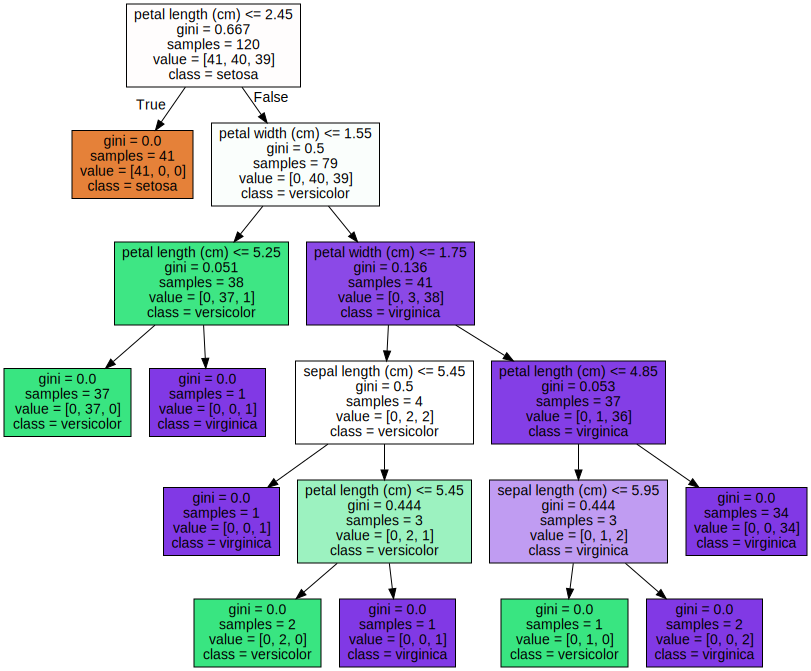

In [7]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [8]:
import seaborn as sns
import numpy as np
%matplotlib inline

In [10]:
print(np.round(dt_clf.feature_importances_,3))

[0.025 0.    0.555 0.42 ]


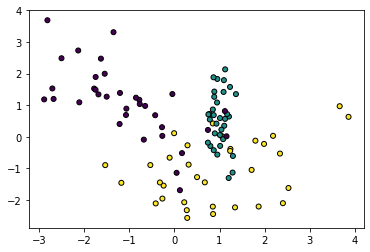

In [19]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

X_features, y_labels = make_classification(n_features = 2, n_redundant = 0, n_informative = 2, n_classes = 3,\
                                          n_clusters_per_class=1, random_state = 0)
plt.scatter (X_features[:,0],X_features[:,1],marker = 'o', c=y_labels, s = 25, edgecolor = 'k')

In [20]:
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)

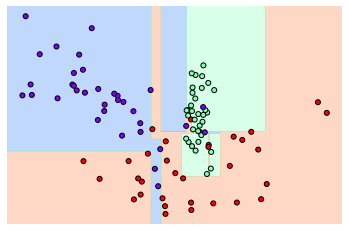

In [21]:
dt_clf = DecisionTreeClassifier(random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

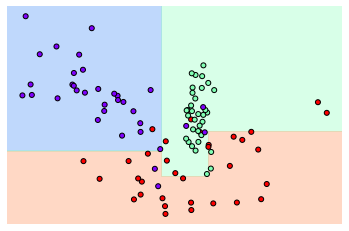

In [26]:
dt_clf = DecisionTreeClassifier(random_state=156,min_samples_leaf=6).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

In [27]:
import pandas as pd

In [28]:
feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',header = None, names = ['column_index', 'column_name'])
feature_name = feature_name_df.iloc[:,1].values.tolist()

In [29]:
feature_name_df

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y
...,...,...
556,557,"angle(tBodyGyroMean,gravityMean)"
557,558,"angle(tBodyGyroJerkMean,gravityMean)"
558,559,"angle(X,gravityMean)"
559,560,"angle(Y,gravityMean)"


In [30]:
feature_dup_df = feature_name_df.groupby('column_name').count()

In [33]:
feature_name_df['column_name']

0                         tBodyAcc-mean()-X
1                         tBodyAcc-mean()-Y
2                         tBodyAcc-mean()-Z
3                          tBodyAcc-std()-X
4                          tBodyAcc-std()-Y
                       ...                 
556        angle(tBodyGyroMean,gravityMean)
557    angle(tBodyGyroJerkMean,gravityMean)
558                    angle(X,gravityMean)
559                    angle(Y,gravityMean)
560                    angle(Z,gravityMean)
Name: column_name, Length: 561, dtype: object

In [61]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_dup_df.reset_index(),how = 'outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(
    lambda x : x[0]+'_'+str(x[1]) if x[1]>0 else x[0],axis =1)
    new_feature_name_df = new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df

In [62]:
def get_human_dataset():
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [64]:
from sklearn.metrics import accuracy_score
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train , y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [73]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth' : [8,12,16,20,],
    'min_samples_split' : [16, 24]
}
grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring = 'accuracy', cv = 5, verbose=1)
grid_cv.fit(X_train,y_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.8548794147162603
{'max_depth': 8, 'min_samples_split': 16}


In [75]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
print(accuracy_score(y_test, pred1))

0.8717339667458432
